In [1]:

from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
#tf.enable_eager_execution()

import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
#from keras import optimizers

In [2]:

# verify TensorFlow version

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Version:  2.12.0
Eager mode:  True
Hub version:  0.13.0
GPU is available


In [3]:
# Loading Data

zip_file = tf.keras.utils.get_file(origin='https://storage.googleapis.com/plantdata/PlantVillage.zip', 
                                   fname='PlantVillage.zip', extract=True)

856839084/856839084 [==============================] - 49s 0us/step


In [4]:
# Prepare training and validation dataset

data_dir = os.path.join(os.path.dirname(zip_file), 'PlantVillage')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

In [5]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"

In [6]:
print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))

total images for training : /root/.keras/datasets/PlantVillage/train : 43444files
total images for validation : /root/.keras/datasets/PlantVillage/validation : 10861files


In [7]:
# Label mapping

!!wget https://github.com/obeshor/Plant-Diseases-Detector/archive/master.zip
!unzip master.zip;

Archive:  master.zip
33dc8985c943175a7a1301fe034c01d69bebb8cf
   creating: Plant-Diseases-Detector-master/
   creating: Plant-Diseases-Detector-master/GreenDoctor/
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.gitignore  
   creating: Plant-Diseases-Detector-master/GreenDoctor/.idea/
   creating: Plant-Diseases-Detector-master/GreenDoctor/.idea/codeStyles/
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/codeStyles/Project.xml  
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/codeStyles/codeStyleConfig.xml  
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/encodings.xml  
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/jarRepositories.xml  
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/misc.xml  
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/runConfigurations.xml  
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/vcs.xml  
   creating: Plant-Diseases-Detector-master/GreenDoctor

In [8]:
import json

with open('Plant-Diseases-Detector-master/categories.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
    
print (classes)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [9]:
print('Number of classes:',len(classes))

Number of classes: 38


In [10]:
# Setup Image shape and batch size
IMAGE_SHAPE = (224, 224)

BATCH_SIZE = 64 #@param {type:"integer"}
     

In [11]:
# Data Preprocessing
# Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE)

Found 10861 images belonging to 38 classes.
Found 43444 images belonging to 38 classes.


In [13]:
# Build the model
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])


In [14]:
# Specify Loss Function and Optimizer
LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])


In [16]:
# Train Model

EPOCHS=10 #@param {type:"integer"}

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

<ipython-input-16-7857cf779f12>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
678/678 [==============================] - 625s 914ms/step - loss: 0.7374 - accuracy: 0.7769 - val_loss: 0.2976 - val_accuracy: 0.9041
Epoch 2/10
678/678 [==============================] - 625s 923ms/step - loss: 0.4351 - accuracy: 0.8572 - val_loss: 0.2508 - val_accuracy: 0.9201
Epoch 3/10
678/678 [==============================] - 613s 904ms/step - loss: 0.3923 - accuracy: 0.8726 - val_loss: 0.2309 - val_accuracy: 0.9259
Epoch 4/10
678/678 [==============================] - 621s 916ms/step - loss: 0.3691 - accuracy: 0.8792 - val_loss: 0.2212 - val_accuracy: 0.9262
Epoch 5/10
678/678 [==============================] - 608s 897ms/step - loss: 0.3507 - accuracy: 0.8832 - val_loss: 0.2108 - val_accuracy: 0.9309
Epoch 6/10
678/678 [==============================] - 594s 875ms/step - loss: 0.3407 - accuracy: 0.8882 - val_loss: 0.1970 - val_accuracy: 0.9331
Epoch 7/10
678/678 [==============================] - 610s 899ms/step - loss: 0.3267 - accuracy: 0.8926 - val_loss: 0.1972 -

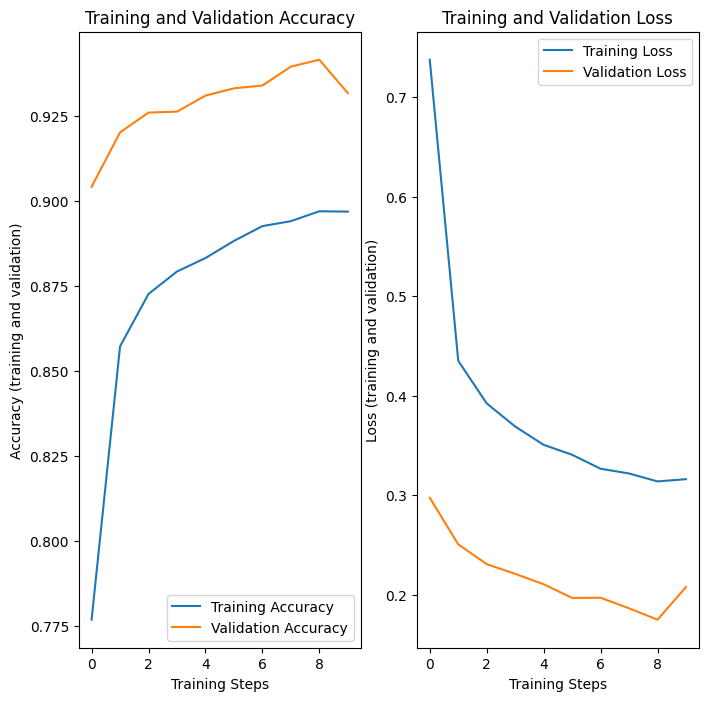

In [17]:
# Check Performance
# Random test
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()
     

In [18]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SHAPE[0], IMAGE_SHAPE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: Orange___Haunglongbing_(Citrus_greening), file: Orange___Haunglongbing_(Citrus_greening)/e6eaeef5-88d8-4b84-8d94-6fd41e01f093___UF.Citrus_HLB_Lab 0974.JPG
1/1 [==============================] - 1s 902ms/step
PREDICTED: class: Pepper,_bell___healthy, confidence: 0.693943


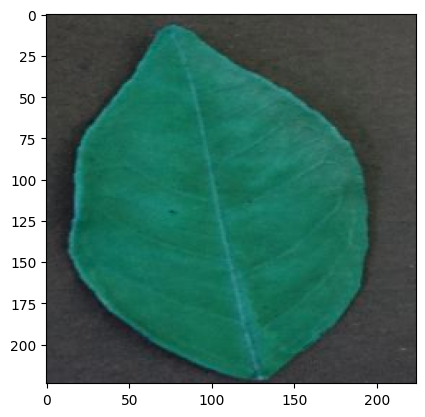

<Figure size 640x480 with 0 Axes>

SOURCE: class: Grape___Leaf_blight_(Isariopsis_Leaf_Spot), file: Grape___Leaf_blight_(Isariopsis_Leaf_Spot)/3b233488-833a-4f3f-af84-cebed0a1763f___FAM_L.Blight 1636.JPG
1/1 [==============================] - 0s 30ms/step
PREDICTED: class: Grape___Leaf_blight_(Isariopsis_Leaf_Spot), confidence: 0.999913


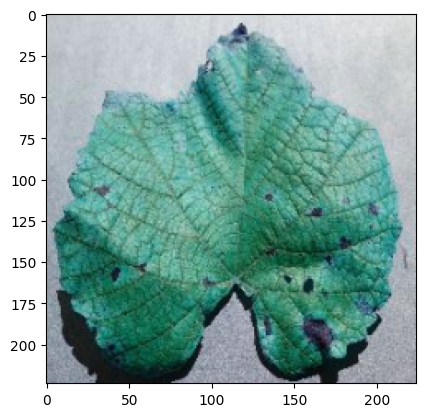

SOURCE: class: Tomato___Bacterial_spot, file: Tomato___Bacterial_spot/ef110350-8e1f-4eb2-a384-037eafaf1089___GCREC_Bact.Sp 5980.JPG
1/1 [==============================] - 0s 28ms/step
PREDICTED: class: Tomato___Bacterial_spot, confidence: 0.510203


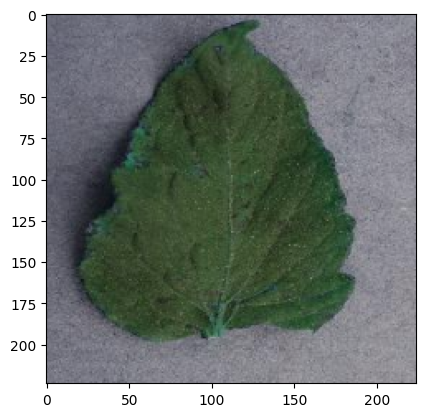

<Figure size 640x480 with 0 Axes>

SOURCE: class: Grape___Esca_(Black_Measles), file: Grape___Esca_(Black_Measles)/28db1d81-876f-466f-97ac-c009bae14501___FAM_B.Msls 3929.JPG
1/1 [==============================] - 0s 32ms/step
PREDICTED: class: Grape___Esca_(Black_Measles), confidence: 0.974013


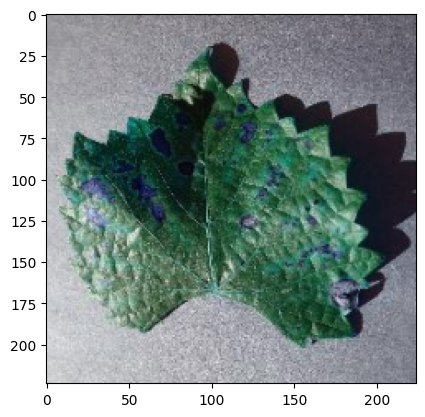

<Figure size 640x480 with 0 Axes>

SOURCE: class: Grape___Esca_(Black_Measles), file: Grape___Esca_(Black_Measles)/7e50ddbb-6454-46ba-9c6d-c8b01f7d288e___FAM_B.Msls 1083.JPG
1/1 [==============================] - 0s 36ms/step
PREDICTED: class: Grape___Esca_(Black_Measles), confidence: 0.999415


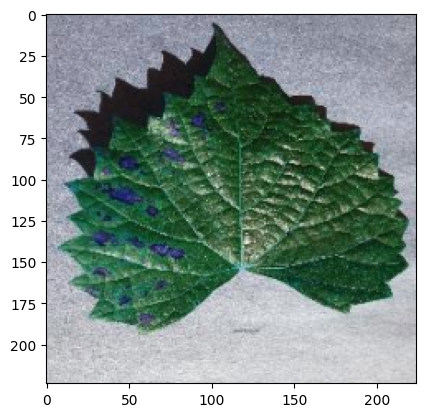

<Figure size 640x480 with 0 Axes>

In [19]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [31]:
# Export as saved model
import time
t = time.time()

# export_path = "/tmp/saved_models/{}".format(int(t))
# tf.keras.experimental.export_saved_model(model, export_path)
saved_model_path = "./my_model" # or you can simply use 'my_mode.h5'
model.save(saved_model_path) #save your model 
# export_path
saved_model_path

'./my_model'

In [32]:
# Now confirm that we can reload it, and it still gives the same results
# reloaded = tf.keras.experimental.load_from_saved_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})
# to reload your model 
model = tf.keras.models.load_model(saved_model_path)

In [35]:
def predict_reload(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: Tomato___Late_blight, file: Tomato___Late_blight/f43df4fe-4544-4831-b9f9-a3c7b470b0e0___RS_Late.B 6801.JPG
1/1 [==============================] - 1s 506ms/step
PREDICTED: class: Tomato___Late_blight, confidence: 0.608432


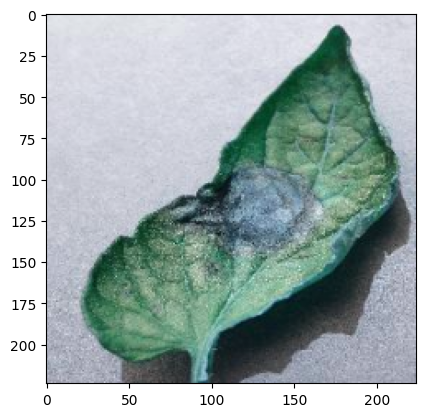

<Figure size 640x480 with 0 Axes>

SOURCE: class: Orange___Haunglongbing_(Citrus_greening), file: Orange___Haunglongbing_(Citrus_greening)/d327002d-b707-430e-b423-8f28f2f45734___CREC_HLB 7614.JPG
1/1 [==============================] - 0s 31ms/step
PREDICTED: class: Orange___Haunglongbing_(Citrus_greening), confidence: 1.000000


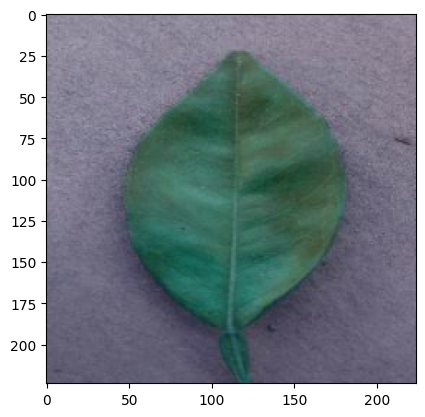

In [36]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 2)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict_reload(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()